In [ ]:
%matplotlib inline

<div class="alert alert-warning">

### Load this Jupyter Notebook into Google Colab for better performance! (use GPU environment)

**Coursera Labs does not provide enough CPU and memory.**
</div>

torchvision model tuning
------------------------------

In this task you will have to run all the steps of the lab and save final model weights into `final_model.pt` file, which you will have to submit as the result of your work into Coursera Lab environment by clicking Submit Assignment button.

Part of the steps are complete, others will require you to do simple excercises.


https://pytorch.org/docs/stable/torchvision/models.html - models trained on ImageNet

First we get the pre-trained model and then use feature extraction for final layers training.

Steps:
-  get data
-  init pre-trained model
-  add new head layer, change output shape for desired dataset
-  define how we train our model (update only final layers or all)
-  train


In [ ]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

Data
------

We will use *hymenoptera_data*: https://download.pytorch.org/tutorial/hymenoptera_data.zip.
It has 2 classes - bees and ants.
To get data we will use class ImageFolder - https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder

As a model we take vgg11_bn - VGG11 trained with batch normalization

Other params:
batch_size - size of the batch, num_classes - amount of different classes in data, num_epochs - how many epochs to train for, finetune - flag to determine if we train only last layers or the whole model




In [ ]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! mkdir data
! unzip hymenoptera_data.zip

--2021-08-11 07:32:48--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.158.70, 52.222.158.75, 52.222.158.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.158.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.2’

hymenoptera_data.zi 100%[===================>]  45.10M   119MB/s    in 0.4s    

2021-08-11 07:32:48 (119 MB/s) - ‘hymenoptera_data.zip.2’ saved [47286322/47286322]

mkdir: cannot create directory ‘data’: File exists
Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mv hymenoptera_data data/
! ls ./data

mv: cannot move 'hymenoptera_data' to 'data/hymenoptera_data': Directory not empty
hymenoptera_data


In [ ]:
data_dir = "./data/hymenoptera_data" # path to data
num_classes = 2                      # amount of classes in new data

batch_size = 8                       # data batch size
num_epochs = 5                       # epochs count
feature_extract = True               # should we train with feature extraction (last layers fine tuning)

Model training
---------------

And helper for layers params setup

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    start = time.time()
    _hist = []
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            _loss, _acc = 0.0, 0

            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _loss += loss.item() * inputs.size(0)
                _acc += torch.sum(preds == labels.data)

            epoch_loss = _loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = _acc.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.6f} Acc: {:.6f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                _hist.append(epoch_acc)
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start
    print('Training finished: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Validation: best score Accuracy: {:6f}'.format(best_acc))

    model.load_state_dict(best_model)
    return model, _hist


def set_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

Model init and update
-----------------------------------

For more details - https://pytorch.org/docs/stable/torchvision/models.html

In this block we change model's final layer. It is hard to automate this step, as each model has its own characteristics. Last layer of CNN model (usually fully conntected) has the same amount of outputs as the dataset classes. All models in torchvision are trained on Imagenet, so the size of the final layer is 1000.

Our goal - get the final layer to have the same inputs amount and change amount of outputs to satisfy the requirements of new dataset.

Important notice to distinguish retraining and feature extraction (final layers training, finetuning): in the last case we want to update only final layer (layers), meaning we ignore gradients calculation for the previous layers, in order to do so we set `required_grad=False` parameter of the layers. By default, the parameter is `True` (including newly created layer, but we do want to update it, that is why we do not set that param for the new layer).

VGG
---

More details about the model - https://arxiv.org/pdf/1409.1556.pdf

In torchvision library there is 8 versions of pre-trained VGG model with different size and batch-normalization usage. We will use VGG-11 with batch-normalization.

In model description we can see: classifier (model's head) includes final layer - Linear with 4096 input params and 1000 outputs:.
```
   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
We can change it by using following code:

`model.classifier[6] = nn.Linear(4096,num_classes)`

We update sixth (last) layer in classifier block of model's layers sequence.

In [ ]:
def set_requires_grad(model, feature_extract):
    if feature_extract:
      for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.vgg11_bn(pretrained=use_pretrained)

    set_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.classifier[6].in_features

    #
    #
    # PUT CODE TO REPLACE LAYER HERE
    #
    #

    input_size = 4096
    model_ft.classifier[6] = nn.Linear(input_size,num_classes)

    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
model_ft = models.vgg11_bn(pretrained=True)

Data loader
---------

Now knowing input data params we can init data loader.
Important notice: models are trained with normalization values, details - https://pytorch.org/docs/master/torchvision/models.html




In [ ]:
# Data normalization
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            data_transforms[x])
    for x in ['train', 'val']
}
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                   shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
x = 'train'
d = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

In [ ]:
class_names = d.classes

type(class_names)

list

Init optimizer
--------------------

Now we have model and data, last thing left is to create optimizer, which will update only required params. We already specified `required_grad` param before.

We have to pass those (and only those) params into SGD for optimization



In [ ]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters() # all params by default
print("Params to update while training:")

if feature_extract:
    # only last layer, update the list
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    # all params, just output
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.002, momentum=0.9)

Params to update while training:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Training and validation
--------------------------------

Now we have to determine loss function and start training process for specified amount of epochs. CPU learning might require some time (depending on the model), and learning rate could be optimized as well (as it is not optimal by default).




In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# training
# TODO: call train_model will all required params:

#model_ft, hist = None, None # train_model(...)

In [ ]:
dataloaders_dict['train']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j].item()]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torch.optim import lr_scheduler

#model_ft = model_ft.to(device)

#criterion = nn.CrossEntropyLoss()


#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)



torch.save(model_ft.state_dict(), 'final_model.pt')


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 2.4291 Acc: 0.5984
val Loss: 0.7136 Acc: 0.7712

Epoch 1/24
----------
train Loss: 0.9905 Acc: 0.6598
val Loss: 0.4869 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.5107 Acc: 0.7664
val Loss: 0.4471 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.3451 Acc: 0.8361
val Loss: 0.3413 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3761 Acc: 0.8443
val Loss: 0.4989 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.3373 Acc: 0.8566
val Loss: 0.7398 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.2540 Acc: 0.8934
val Loss: 0.3280 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.2771 Acc: 0.8893
val Loss: 0.3275 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.1969 Acc: 0.9180
val Loss: 0.3130 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.1937 Acc: 0.9262
val Loss: 0.3327 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.2409 Acc: 0.9016
val Loss: 0.3257 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.1997 Acc: 0.9098
val Loss: 0.3116 Acc: 0.8954

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


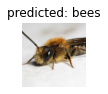

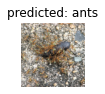

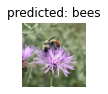

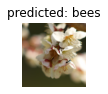

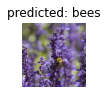

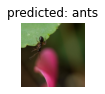

In [ ]:
visualize_model(model_ft)

Save resulting model weights

In [ ]:
torch.save(model_ft.state_dict(), 'final_model1.pt')

Saved file can be found in directory menu on the left in Google Colab interface.

<div class="alert alert-warning">

Save `final_model.pt` file from Google Colab to your computer and than upload it to the Coursera Lab environment. When finish downloading, click "Submit Assignment" in this notebook.

![image.png](attachment:image.png)

</div>